In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

#size of training dataset
train_samples = train.shape[0]

In [2]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [4]:
train.groupby(by='Survived').PassengerId.count()

# double number of not survived that survived

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In [5]:
train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]  ).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def scale(X, fit_scaler=False):
    # Input is a dataframe
    #
    # Note the way of scaling (df[df.columns])
    # we want to mantain the dataframe (instead of numpy array)
    if fit_scaler:
        X[X.columns] = scaler.fit_transform(X[X.columns])
    else:
        X[X.columns] = scaler.transform(X[X.columns])
        
    return X 

def preprocess(df):
    X = df[['Pclass','Sex']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})
    X['Family'] = df.Parch + df.Parch
    
    return X


In [14]:
# plotting a scatter matrix
def plot_matrix(X_train, y_train):
    colormap = {0:'firebrick',1:'steelblue'}
    colors = np.vectorize(colormap.get)(y_train)

    pd.plotting.scatter_matrix(X_train, c=colors, marker = 'o', s=30,
                               hist_kwds={'bins':15}, figsize=(9,9));


In [15]:
def save_to_file(clf, X_test):
    import os

    predictions = clf.predict(X_test)

    passengerId = 892
    file = "PassengerId,Survived" + os.linesep

    for i in range(len(X_test)):
        file += "{},{}".format(passengerId, (int)(predictions[i]))  + os.linesep
        passengerId += 1

    # Save to file
    with open('attempt.txt', 'w') as f:
        f.write(file)

In [8]:
#baseline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

def baseline(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

    dummy = DummyClassifier(random_state=0)

    #be aware of y as column vector
    dummy.fit(X_train, y_train.values.reshape(-1))
    acc = dummy.score(X_val.values, y_val.values.reshape(-1))
    print('Accuracy: {:.2f}\n'.format(acc))
    
    # Combined report with all above metrics
    print(classification_report(y_val, dummy.predict(X_val), target_names=['Not Survived', 'Survived']))


***

## Baseline starts from 0.54

In [9]:
X_train = preprocess(train)
y_train = train[['Survived']]

baseline(X_train, y_train)

Accuracy: 0.54

              precision    recall  f1-score   support

Not Survived       0.63      0.62      0.63       139
    Survived       0.39      0.40      0.40        84

 avg / total       0.54      0.54      0.54       223



***

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

def check_model(X, y):
    rfc = RandomForestClassifier(random_state=0)
    scores = cross_validate(rfc, X, y, cv=10, scoring='accuracy')

    print("Train scores: {:.3f}".format(scores['train_score'].mean()))
    print("Test scores: {:.3f}".format(scores['test_score'].mean()))
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    rfc.fit(X_train, y_train)
    
    y_pred = rfc.predict(X_val)
    print("Accuracy: {:.3f}".format(accuracy_score(y_val, y_pred)))

    y_probs = rfc.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_probs[:,1])
    print("AUC:{:.3f}".format(auc))
    
    print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
    
    return rfc


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

def grid_search(X, y, test_size=0.25):
    max_range = np.append(np.arange(1, X.shape[1]+1), None)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=0)
    params = {'n_estimators': [2, 3, 5, 7, 10, 20],
              'class_weight': ['balanced', {1:2}, {1:3}, {1:4}, {1:5}, {1:10}, {1:20}],
              'max_features': max_range,
              'max_depth': max_range}

    rfc = RandomForestClassifier(random_state=0)
    grid_rfc = GridSearchCV(rfc, param_grid=params, cv=10, scoring='accuracy')
    grid_rfc.fit(X_train, y_train)

    best_rfc = grid_rfc.best_estimator_

    y_pred = best_rfc.predict(X_val)
    print("Accuracy: {:.3f}".format(accuracy_score(y_val, y_pred)))

    y_probs = best_rfc.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_probs[:,1])
    print("AUC:{:.3f}".format(auc))
    
    print("Best params: {}\n".format(grid_rfc.best_params_))
    print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
    
    return best_rfc


In [12]:
X_train = preprocess(train).values
y_train = train[['Survived']].values.reshape(-1)

rfc = check_model(X_train, y_train)

Train scores: 0.807
Test scores: 0.795
Accuracy: 0.794
AUC:0.867
              precision    recall  f1-score   support

Not Survived       0.83      0.85      0.84       139
    Survived       0.74      0.70      0.72        84

 avg / total       0.79      0.79      0.79       223



In [16]:
X_test = preprocess(test)
save_to_file(rfc, X_test)

## 0.77511 in Kaggle!!!
***

In [17]:
X_train = scale(preprocess(train), True)
rfc = check_model(X_train, y_train)

Train scores: 0.807
Test scores: 0.795
Accuracy: 0.794
AUC:0.868
              precision    recall  f1-score   support

Not Survived       0.83      0.85      0.84       139
    Survived       0.74      0.70      0.72        84

 avg / total       0.79      0.79      0.79       223



In [18]:
X_test = preprocess(test)
X_test = scale(X_test)
save_to_file(rfc, X_test)

### Kaggle 0.77511 -> Same results
***

In [23]:
def preprocess_2(df):
    X = df[['Pclass','Sex']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})  
    X['Family'] = (df.SibSp*df.Parch)/(df.SibSp + df.Parch + 0.0001)
    
    X['Age'] = df.Age.fillna(df.Age.median())
    group_pclass_fare = df.groupby(by='Pclass').Fare.median()
    X['Fare'] = np.where(df.Fare.isnull(), group_pclass_fare[df.Pclass], df.Fare)
    
    return X

In [26]:
X_train = preprocess_2(train)
rfc = check_model(X_train, y_train)

Train scores: 0.965
Test scores: 0.816
Accuracy: 0.852
AUC:0.862
              precision    recall  f1-score   support

Not Survived       0.86      0.91      0.89       139
    Survived       0.84      0.75      0.79        84

 avg / total       0.85      0.85      0.85       223



In [31]:
rfc = grid_search(X_train, y_train, test_size=0.1)

Accuracy: 0.822
AUC:0.856
Best params: {'class_weight': {1: 2}, 'max_features': 2, 'n_estimators': 20, 'max_depth': None}

              precision    recall  f1-score   support

Not Survived       0.80      0.92      0.85        51
    Survived       0.87      0.69      0.77        39

 avg / total       0.83      0.82      0.82        90



In [32]:
X_test = preprocess_2(test)
save_to_file(rfc, X_test)

### Kaggle 0.74641
***

In [192]:
dict_names = {
            "Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"

            }

In [181]:
#list_names = set([v for v in dict_names.values()])
#list_names = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]  ).unique()

#dict_names = {v:k for k,v in enumerate(list_names)}

In [313]:
def preprocess_3(df):
    X = df[['Pclass','Sex','Age']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})
    
    X['Family'] = (df.SibSp*df.Parch)/(df.SibSp + df.Parch + 0.0001)
    X['SibSp'] = df.SibSp
    X['Parch'] = df.Parch
    
    X['Name'] = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1])
    X.Name = X.Name.map(dict_names)
    
    grouped_name = X.groupby(by=['Sex','Pclass','Name']).Age.median()

    #X['Age'] = np.where(X.Age.isnull(), grouped_name[X.Sex,X.Pclass,X.Name], X.Age)
    X.Age = X.apply(lambda r: grouped_name[r.Sex, r.Pclass, r.Name] if np.isnan(r.Age) else r.Age, axis=1)
    
    #Just in case there is no median() por Sex-Pclass-Name
    if(X.Age.isnull().any()):
        grouped_name_2 = X.groupby(by=['Sex','Pclass']).Age.median()
        X.Age = X.apply(lambda r: grouped_name_2[r.Sex, r.Pclass] if np.isnan(r.Age) else r.Age, axis=1)
    
    ## Select median() of fare from <Pclass + Name>
    grouped_pclass_fare = df.groupby(by='Pclass').Fare.median()
    X['Fare'] = np.where(df.Fare.isnull(), grouped_pclass_fare[df.Pclass], df.Fare)
    
    #return X[['Pclass','Sex','Age','SibSp','Parch','Family','Fare']]
    return pd.get_dummies(X)


In [315]:
X_train = preprocess_3(train)

rfc = check_model(X_train, y_train)

#rfc = grid_search(X_train, y_train, test_size=0.1)
X_test = preprocess_3(test)
save_to_file(rfc, X_test)

Train scores: 0.970
Test scores: 0.810
Accuracy: 0.821
AUC:0.869
              precision    recall  f1-score   support

Not Survived       0.84      0.88      0.86       139
    Survived       0.78      0.73      0.75        84

 avg / total       0.82      0.82      0.82       223



<IPython.core.display.Javascript object>


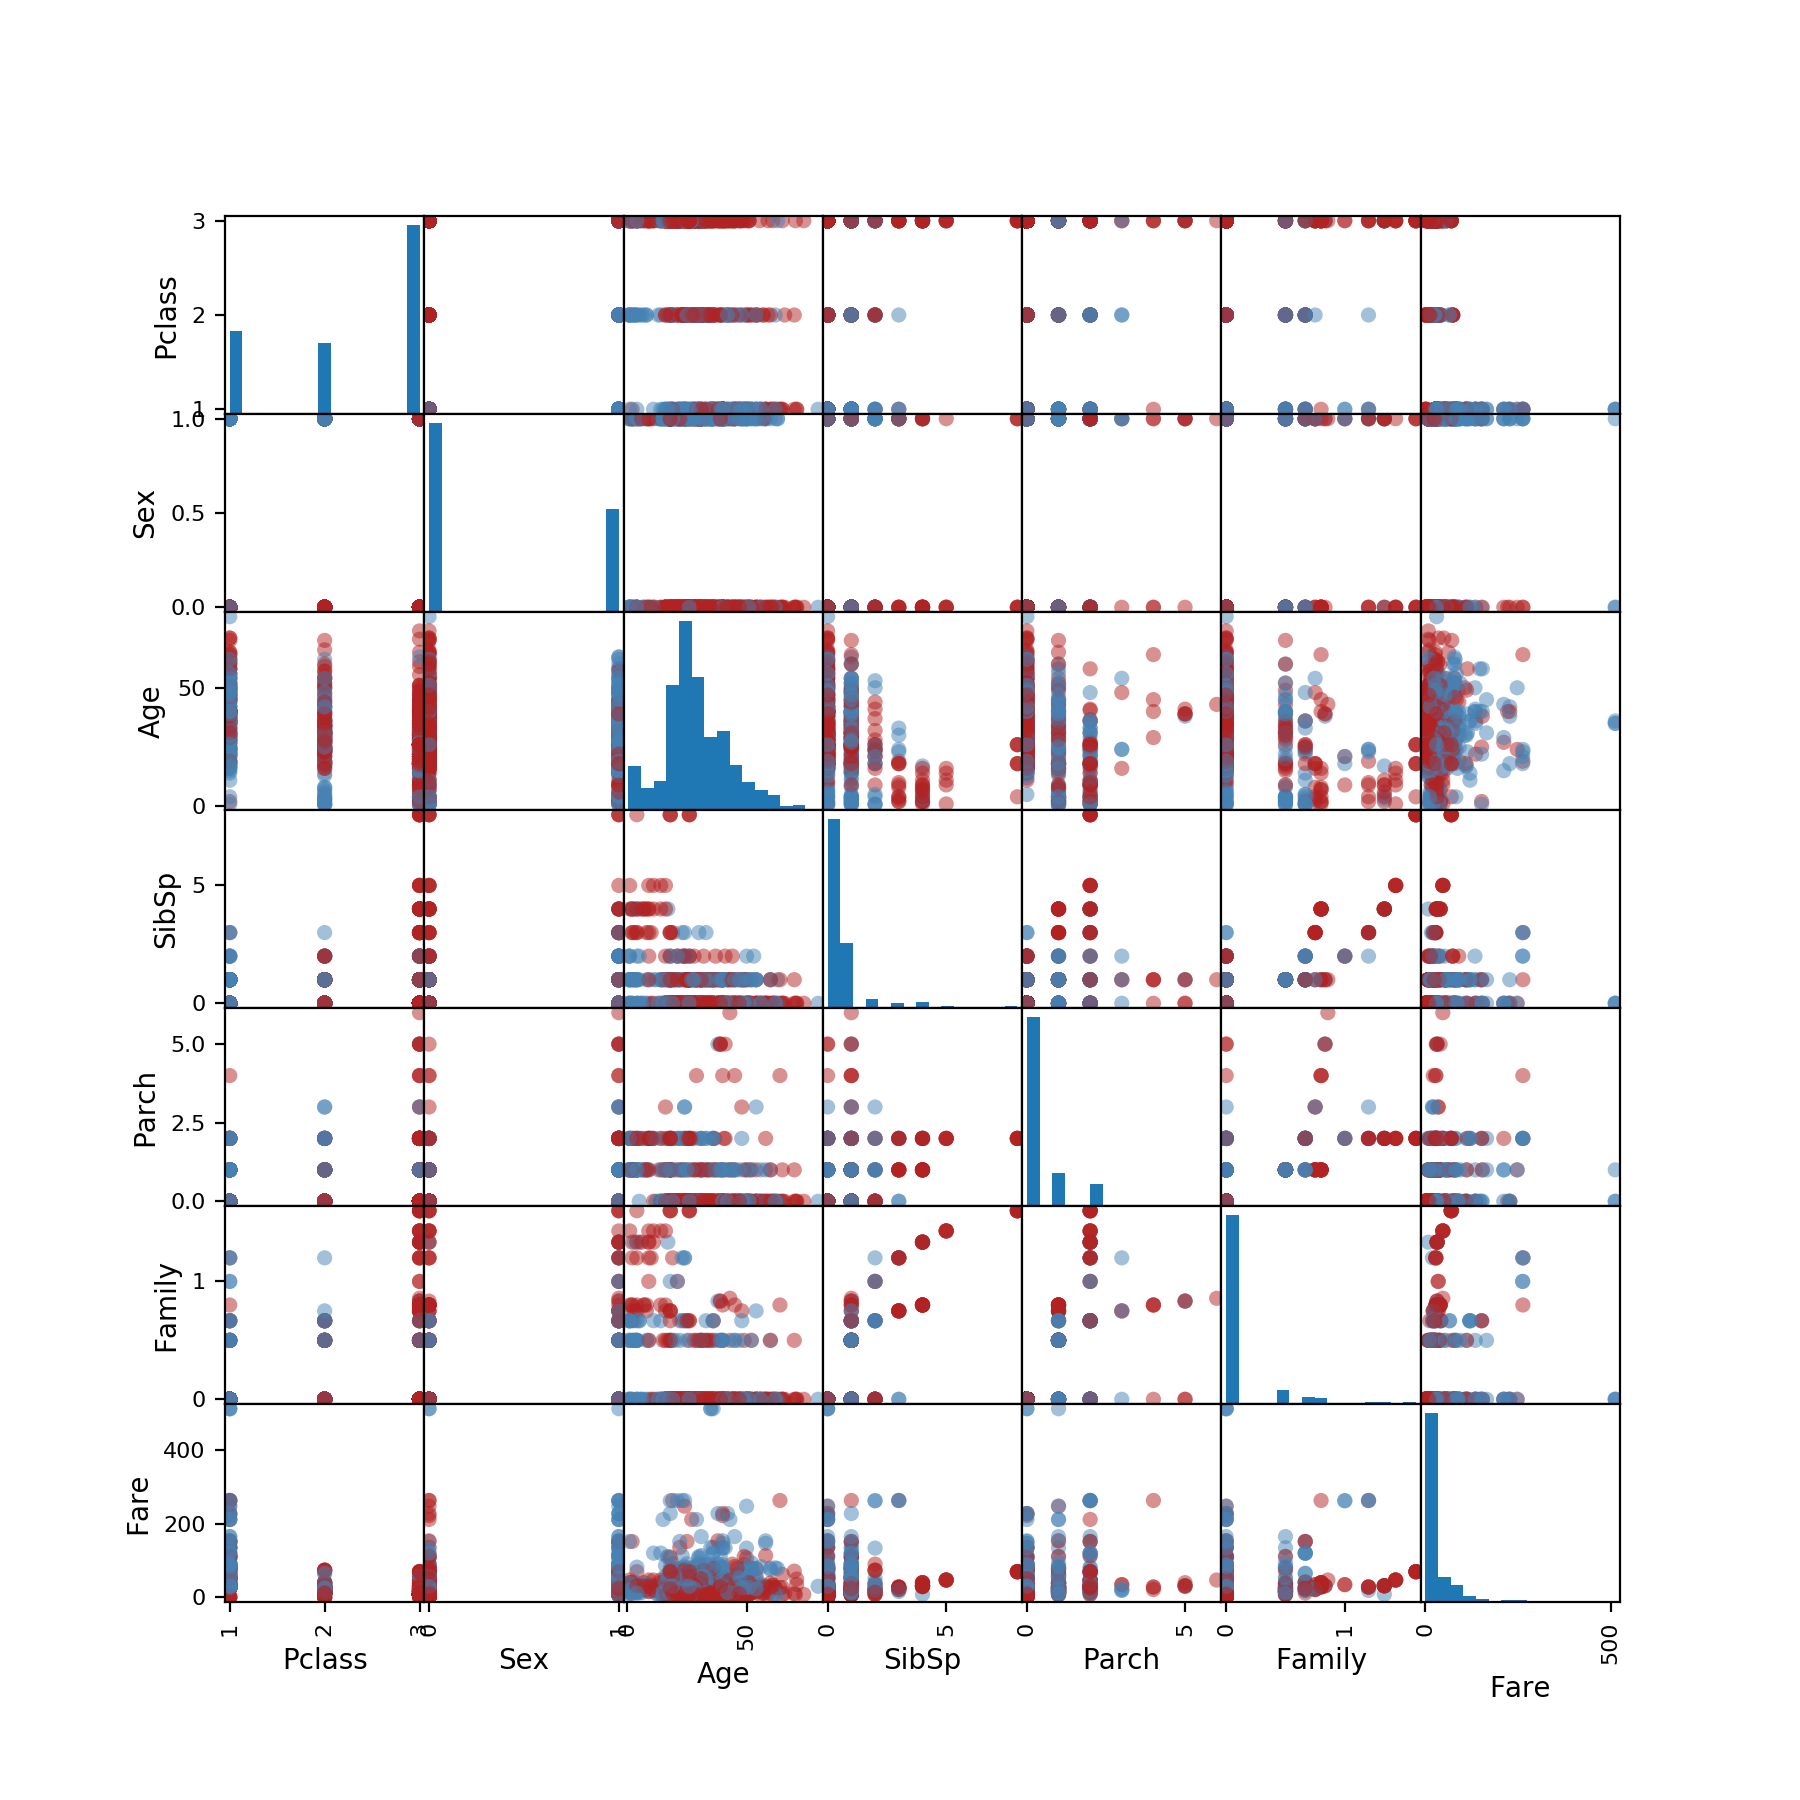

In [333]:
plot_matrix(X_train[['Pclass','Sex','Age','SibSp','Parch','Family','Fare']], y_train)

***

In [35]:
def preprocess_4(df):
    #X = df[['Pclass','Age','SibSp','Parch','Fare','Sex', 'Embarked']]
    X = df[['Pclass','Sex']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})
    X['Embarked'] = df.Embarked.fillna('U')
    X.Embarked = X.Embarked.map({'S':0,'C':1,'Q':2,'U':3})
    
    X['Family'] = (df.SibSp*df.Parch)/(df.SibSp + df.Parch + 0.0001)
    
    X['Age'] = df.Age.fillna(df.Age.median())
    group_pclass_fare = df.groupby(by='Pclass').Fare.median()
    X['Fare'] = np.where(df.Fare.isnull(), group_pclass_fare[df.Pclass], df.Fare)
    
    #X['Deck'] = df.Cabin.str[0]
    #X.loc[X.Deck.isnull(), 'Deck'] = 'NaN'
    #X['Room'] = 
    #print(df[~df.Cabin.isnull()].Cabin.str.split())
    #X.Deck = X.Deck.map({'NaN':0, 'F':1, 'E':2, 'C':3, 'D':4, 'B':5, 'G':6, 'A':7, 'T':8})
    
    return X

In [110]:
def preprocess_5(df):
    #X = df[['Pclass','Age','SibSp','Parch','Fare','Sex', 'Embarked']]
    X = df[['Pclass','Sex']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})
    X['Embarked'] = df.Embarked.fillna('U')
    X.Embarked = X.Embarked.map({'S':0,'C':1,'Q':2,'U':3})
    
    X['Family'] = (df.SibSp*df.Parch)/(df.SibSp + df.Parch + 0.0001)
    
    X['Age'] = df.Age.fillna(df.Age.median())
    group_pclass_fare = df.groupby(by='Pclass').Fare.median()
    X['Fare'] = np.where(df.Fare.isnull(), group_pclass_fare[df.Pclass], df.Fare)
    
    X['Deck'] = df.Cabin.str[0]
    X.loc[X.Deck.isnull(), 'Deck'] = 'NaN'
    #print(df[~df.Cabin.isnull()].Cabin.str.split())
    X.Deck = X.Deck.map({'NaN':0, 'F':1, 'E':2, 'C':3, 'D':4, 'B':5, 'G':6, 'A':7, 'T':8})
    
    X['Room'] = train[~train.Cabin.isnull()].Cabin.str.split().str.get(0)
    X.Room = X.Room.str[1:].fillna(0)
    X.Room = X.Room.str[1:]
    X.loc[X.Room.isnull(), 'Room'] = 0
    X.Room = pd.to_numeric(X.Room)
    
    return X
